In [31]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
locloc = "BigDataCubes\CombinedDatasets" 
namename = "\Part0"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
#all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [33]:
"""
all_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_masks *= (1.0/all_masks.max())
plt.imshow(all_masks[0])
print(all_masks.shape) """

'\nall_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]\nall_masks *= (1.0/all_masks.max())\nplt.imshow(all_masks[0])\nprint(all_masks.shape) '

In [34]:
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    testanswers = all_normals[mylist]

    imgimg = locmodel.predict([inputs])

    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(testanswers, axis=1)
    r2 =  np.concatenate(imgimg, axis=1)

    
    #r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    #r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    #r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0, r1, r2], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [35]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_normals))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape)

(3420, 64, 64, 3)


In [36]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    #z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    #do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    resh = keras.layers.Reshape((16, 16, 4))(do)
    
    #anticonv1 = keras.layers.Conv2DTranspose(4, (5, 5), activation='relu')(resh)
    #anticonv2 = keras.layers.Conv2DTranspose(4, (5, 5), activation='relu')(anticonv1)
    #anticonv3 = keras.layers.Conv2DTranspose(4, (5, 5), activation='relu')(anticonv2)
    #anticonv4 = keras.layers.Conv2DTranspose(4, (5, 5), activation='relu')(anticonv3)
    c1 = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='relu')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='relu')(c1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [37]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00006)

In [38]:
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 7)         259       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 7)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1792)              0   

In [44]:
model.fit(train_dataset, epochs=100)

Epoch 1/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0177
Epoch 2/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0177
Epoch 3/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0176
Epoch 4/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0176
Epoch 5/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0176
Epoch 6/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0175
Epoch 7/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0175
Epoch 8/100
53/53 [==============================] - 1s 15ms/step - loss: 0.0174
Epoch 9/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0173
Epoch 10/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0172
Epoch 11/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0171
Epoch 12/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0170
Epoch 13/100
53/53 [=====

1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0225189].


(384, 768, 3)
Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  


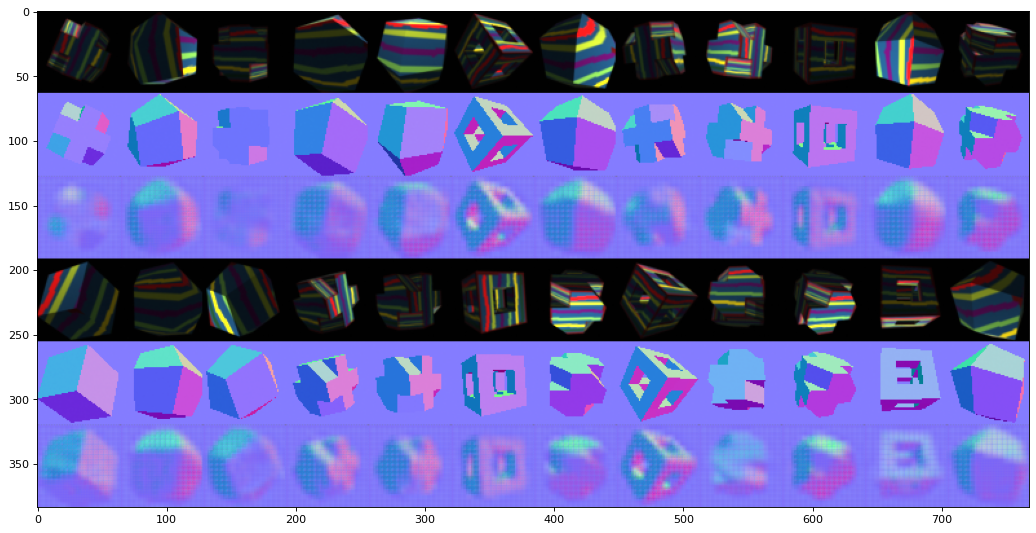

In [45]:
toinset = np.array([i * 100 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 100 + 50 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
print(bigpicture.shape)
plt.figure(figsize=(16, 12), dpi=80)
print("Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  ")
plt.imshow(bigpicture.astype("float32"))

1/1 [==============================] - 0s 20ms/step
(384, 768, 3)
Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0170896].


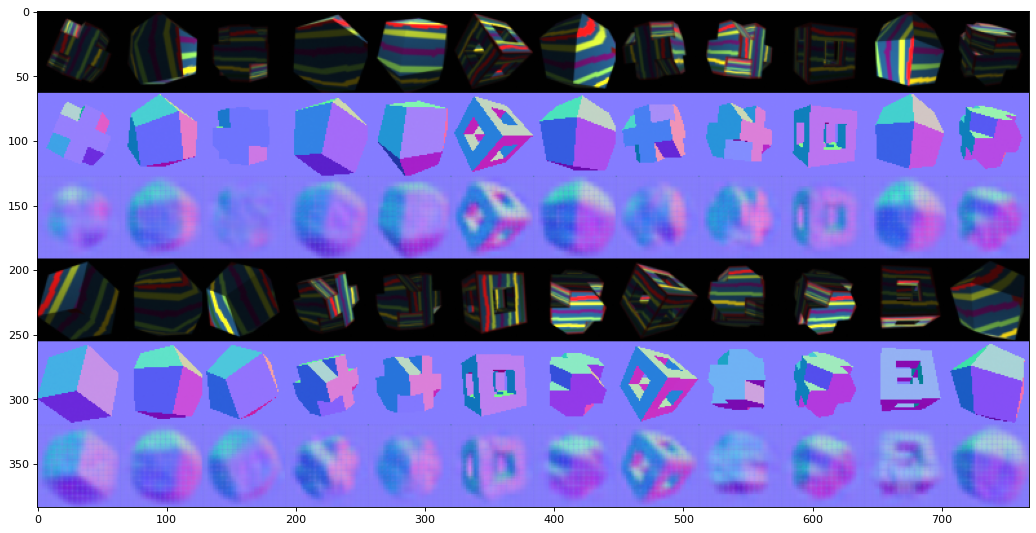

In [15]:
toinset = np.array([i * 100 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 100 + 50 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
print(bigpicture.shape)
plt.figure(figsize=(16, 12), dpi=80)
print("Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  ")
plt.imshow(bigpicture.astype("float32"))

In [18]:
model.evaluate(test_photos, test_normals) 

32/32 [==============================] - 1s 6ms/step - loss: 0.0066


0.00663721514865756

1/1 [==============================] - 0s 184ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921509..1.0300331].


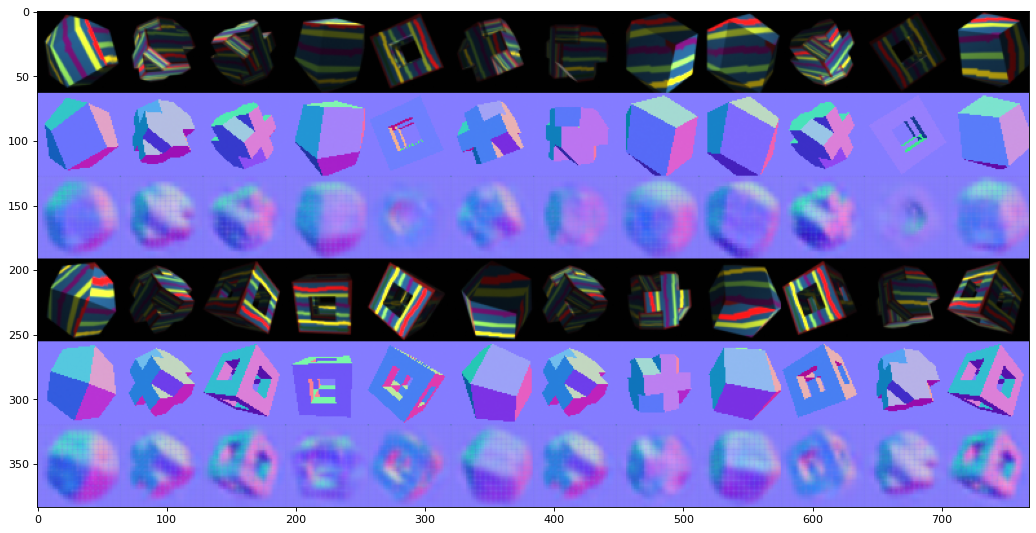

In [19]:
test_predictions = model.predict(test_photos_visual)

r0 =  np.concatenate(test_photos_visual[0:12], axis=1)
r1 =  np.concatenate(test_normals_visual[0:12], axis=1)
r2 =  np.concatenate(test_predictions[0:12], axis=1)
r3 =  np.concatenate(test_photos_visual[12:24], axis=1)
r4 =  np.concatenate(test_normals_visual[12:24], axis=1)
r5 =  np.concatenate(test_predictions[12:24], axis=1)

finalimage = np.concatenate([r0, r1, r2, r3, r4, r5], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(finalimage)

In [147]:
#model.save("big_normals.keras")
# Попытка 1, 400 эпох. 
# Модель очень даже ничего, она прямо хороша. Тестовая выборка дает отличные результаты. Немного размыто, но не страшно

In [17]:
locloc2 = "BigDataCubes\CombinedDatasets" 
namename2 = "\Part1"
all_test_photos = np.load(locloc2 + namename2 + 'Photos.npy')
test_photos = all_test_photos[0:1000]
test_photos_visual = all_test_photos[1000:1024]
del all_test_photos;
all_test_normals = np.load(locloc2 + namename2 + 'Normals.npy')
test_normals = all_test_normals[0:1000]
test_normals_visual = all_test_normals[1000:1024]
del all_test_normals;

In [21]:
model.save("blurry_normals_300.keras")